# EE4375: Fourth Lab Session: FEM One-Dimensional Poisson Equation: Functions, StaticArrays, StructArrays, Type Stability and Benchmarking

## Import Packages  

In [4]:
using LinearAlgebra 
using SparseArrays 
using StructArrays
using StaticArrays

using IterativeSolvers
using Preconditioners

using BenchmarkTools
using Profile
using ProfileView

using Plots 

## Section 1:/ Introduction 

Here we develop a one-dimensional Galerkin finite element code that construct the coefficient matrix as <b>sparse</b> without first constructing a full variant. The code furthermore is <b>type-stable</b> and uses a number of memory <b>allocations</b> that is almost independent of the problem size. We also explore the use of [StructArrays](https://github.com/JuliaArrays/StructArrays.jl) to allows memory-contingent layout is the assembly process. We currently lack the tools to verify the efficiency of this latter tool. 

## Section 2:/ One-Dimensional Mesh Generation 

Exercise: extend to from uniform mesh to non-uniform with local refinement to capture skin effect on material interfaces.  

In [5]:
# struct to hold a single mesh element
struct Element
  p1::Float64   # coordinate left-most node
  p2::Float64   # coordinate right-most node
  e1::Int64     # global index left-most node
  e2::Int64     # global index right-most node
end

In [6]:
# function to generate a mesh on the interval 0 <= x <= 1.   
function generateMesh(N::Int64)
    h::Float64 = 1/N
    x = Vector{Float64}(0:h:1) 
    mesh = StructArray{Element}((x[1:end-1], x[2:end], Vector(1:N), Vector(2:N+1)))
    return mesh;
end 

generateMesh (generic function with 1 method)

In [7]:
# test function for correctness of output 
mesh = generateMesh(4)
typeof(mesh)

StructVector{Element, NamedTuple{(:p1, :p2, :e1, :e2), Tuple{Vector{Float64}, Vector{Float64}, Vector{Int64}, Vector{Int64}}}, Int64} (alias for StructArray{Element, 1, NamedTuple{(:p1, :p2, :e1, :e2), Tuple{Array{Float64, 1}, Array{Float64, 1}, Array{Int64, 1}, Array{Int64, 1}}}, Int64})

In [8]:
# test function for type stability 
@code_warntype generateMesh(4);

MethodInstance for generateMesh(::Int64)
  from generateMesh(N::Int64) in Main at In[6]:2
Arguments
  #self#::Core.Const(generateMesh)
  N::Int64
Locals
  mesh::StructVector{Element, NamedTuple{(:p1, :p2, :e1, :e2), Tuple{Vector{Float64}, Vector{Float64}, Vector{Int64}, Vector{Int64}}}, Int64}
  x::Vector{Float64}
  h::Float64
Body::StructVector{Element, NamedTuple{(:p1, :p2, :e1, :e2), Tuple{Vector{Float64}, Vector{Float64}, Vector{Int64}, Vector{Int64}}}, Int64}
1 ─ %1  = (1 / N)::Float64
│   %2  = Base.convert(Main.Float64, %1)::Float64
│         (h = Core.typeassert(%2, Main.Float64))
│   %4  = Core.apply_type(Main.Vector, Main.Float64)::Core.Const(Vector{Float64})
│   %5  = (0:h:1)::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}
│         (x = (%4)(%5))
│   %7  = Core.apply_type(Main.StructArray, Main.Element)::Core.Const(StructArray{Element})
│   %8  = x::Vector{Float64}
│   %9  = Base.lastindex(x)::Int64
│   %10 = (%9 - 1)::Int64
│   %11

In [15]:
# test function for number of allocations and CPU time
# observe how the number of memory allocations only depends midly on the mesh size 
@time generateMesh(10);
@time generateMesh(100);
@time generateMesh(1000);
@time generateMesh(10000);

  0.000051 seconds (5 allocations: 720 bytes)
  0.000006 seconds (5 allocations: 4.375 KiB)
  0.000007 seconds (5 allocations: 39.750 KiB)
  0.000090 seconds (10 allocations: 390.922 KiB)


## Section 3/: Linear System Generation as Sparse From the Start 

### Section 1.3: Coefficient Matrix Generation

Note that the function generateMatrix() given below appears to be type-stable although input argument mesh does not carry any type annotation. The precise reason for this is still to be described here. 

Note that in the function generateMatrix() given below the variables Iloc, Jloc, Aloc do not require pre-allocation. Declaring these variables instead as static arrays appears to be sufficient to obtain a type stable function.  

In [18]:
function generateLocalMatrix(element::Element)
    h::Float64 = element.p2 - element.p1
    Iloc = SA[element.e1, element.e1, element.e2, element.e2]
    Jloc = SA[element.e1, element.e2, element.e1, element.e2]
    Aloc = SA_F64[1/h, -1/h, -1/h, 1/h]
    return Iloc, Jloc, Aloc
end

function generateMatrix(mesh)
    
    #..recover number of elements  
    N::Int64 = length(mesh) 
    dofperelem::Int64 = 4; 
    
    #..preallocate the memory for local matrix contributions 
    Avalues = zeros(Float64,dofperelem*N)
    I = zeros(Int64,length(Avalues))
    J = zeros(Int64,length(Avalues))

    for i = 1:N #..loop over number of elements..
        element::Element = mesh[i]
        Iloc, Jloc, Aloc = generateLocalMatrix(element) 
        irng = SA[4*i-3, 4*i-2, 4*i-1, 4*i] 
        I[irng] .= Iloc 
        J[irng] .= Jloc 
        Avalues[irng] .= Aloc         
    end
    
    A = sparse(I,J,Avalues)
   
    return A; 
end

generateMatrix (generic function with 1 method)

In [11]:
@code_warntype generateMatrix(mesh)

MethodInstance for generateMatrix(::StructVector{Element, NamedTuple{(:p1, :p2, :e1, :e2), Tuple{Vector{Float64}, Vector{Float64}, Vector{Int64}, Vector{Int64}}}, Int64})
  from generateMatrix(mesh) in Main at In[7]:9
Arguments
  #self#::Core.Const(generateMatrix)
  mesh::StructVector{Element, NamedTuple{(:p1, :p2, :e1, :e2), Tuple{Vector{Float64}, Vector{Float64}, Vector{Int64}, Vector{Int64}}}, Int64}
Locals
  @_3::Union{Nothing, Tuple{Int64, Int64}}
  A::SparseMatrixCSC{Float64, Int64}
  J::Vector{Int64}
  I::Vector{Int64}
  Avalues::Vector{Float64}
  dofperelem::Int64
  N::Int64
  @_10::Int64
  i::Int64
  irng::SVector{4, Int64}
  Aloc::SVector{4, Float64}
  Jloc::SVector{4, Int64}
  Iloc::SVector{4, Int64}
  element::Element
Body::SparseMatrixCSC{Float64, Int64}
1 ─       Core.NewvarNode(:(A))
│   %2  = Main.length(mesh)::Int64
│   %3  = Base.convert(Main.Int64, %2)::Int64
│         (N = Core.typeassert(%3, Main.Int64))
│   %5  = Base.convert(Main.Int64, 4)::Core.Const(4)
│       

In [21]:
# test function for number of allocations and CPU time
# observe how the number of memory allocations only depends midly on the mesh size
mesh = generateMesh(10);    @time generateMatrix(mesh);
mesh = generateMesh(100);   @time generateMatrix(mesh);
mesh = generateMesh(1000);  @time generateMatrix(mesh); 
mesh = generateMesh(10000); @time generateMatrix(mesh); 

  0.000063 seconds (14 allocations: 3.125 KiB)
  0.000015 seconds (14 allocations: 23.969 KiB)
  0.000094 seconds (21 allocations: 227.859 KiB)
  0.000634 seconds (24 allocations: 2.214 MiB)


### Section 2.3: Right-Hand Side Vector Generation

Providing sourceFct as argument causes implementation to allocate. This is still left to be explained. 

In [23]:
# function generateLocalVector(element::Element,sourceFct::Function)
function generateLocalVector(element::Element)
    h::Float64 = element.p2 - element.p1
    Iloc = SA[element.e1, element.e2]
    f1::Float64 = (h/2.)*sourceFct(element.p1)
    f2::Float64 = (h/2.)*sourceFct(element.p2)
    floc = SA_F64[f1, f2]
    return Iloc, floc
end

# function generateVector(mesh,sourceFct::Function)
function generateVector(mesh)
    
    #..recover number of elements  
    N::Int64   = length(mesh)
    Np1::Int64 = N+1 
    
    #..preallocate the memory for local martrix contributions 
    f = zeros(Float64,Np1)

    for i = 1:N #..loop over number of elements..
        element::Element = mesh[i]
        # Iloc, floc = generateLocalVector(element,sourceFct) 
        Iloc, floc = generateLocalVector(element)                         
        f[Iloc] .+= floc          
    end
   
    return f; 
end

generateVector (generic function with 1 method)

In [24]:
function sourceFct(x::Float64)
    return x*sin(π*x)
end

sourceFct (generic function with 1 method)

In [25]:
# @code_warntype sourceFct(.2)

In [27]:
# observe again how the number of memory allocations only depends midly on the mesh size
mesh = generateMesh(10);    @time f = generateVector(mesh);
mesh = generateMesh(100);   @time f = generateVector(mesh);
mesh = generateMesh(1000);  @time f = generateVector(mesh);
mesh = generateMesh(10000); @time f = generateVector(mesh);

  0.000010 seconds (1 allocation: 144 bytes)
  0.000006 seconds (1 allocation: 896 bytes)
  0.000020 seconds (1 allocation: 8.000 KiB)
  0.000134 seconds (2 allocations: 78.234 KiB)


In [29]:
@code_warntype generateVector(mesh)

MethodInstance for generateVector(::StructVector{Element, NamedTuple{(:p1, :p2, :e1, :e2), Tuple{Vector{Float64}, Vector{Float64}, Vector{Int64}, Vector{Int64}}}, Int64})
  from generateVector(mesh) in Main at In[23]:12
Arguments
  #self#::Core.Const(generateVector)
  mesh::StructVector{Element, NamedTuple{(:p1, :p2, :e1, :e2), Tuple{Vector{Float64}, Vector{Float64}, Vector{Int64}, Vector{Int64}}}, Int64}
Locals
  @_3::Union{Nothing, Tuple{Int64, Int64}}
  f::Vector{Float64}
  Np1::Int64
  N::Int64
  @_7::Int64
  i::Int64
  floc::SVector{2, Float64}
  Iloc::SVector{2, Int64}
  element::Element
Body::Vector{Float64}
1 ─ %1  = Main.length(mesh)::Int64
│   %2  = Base.convert(Main.Int64, %1)::Int64
│         (N = Core.typeassert(%2, Main.Int64))
│   %4  = (N + 1)::Int64
│   %5  = Base.convert(Main.Int64, %4)::Int64
│         (Np1 = Core.typeassert(%5, Main.Int64))
│         (f = Main.zeros(Main.Float64, Np1))
│   %8  = (1:N)::Core.PartialStruct(UnitRange{Int64}, Any[Core.Const(1), Int64])


## Section 4: Solve Process 

  0.000226 seconds (67 allocations: 552.297 KiB)


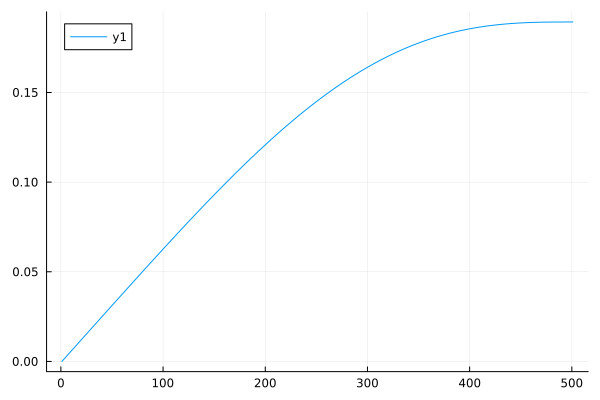

In [30]:
N = 500 
mesh = generateMesh(N)

function sourceFct(x::Float64)
    return x*sin(π*x)
end

A = generateMatrix(mesh) # force compilation 
f = generateVector(mesh) # force compilation

function generateSolution(A,f)
    #..handle essential boundary conditions 
    A[1,1] = 1.; A[1,2] = 0.; f[1] = 0.;
    u = A\f 
    return u 
end

u = generateSolution(A,f) # force compilation 
@time u = generateSolution(A,f)

plot(u)

In [32]:
# observe again how the number of memory allocations only depends midly on the mesh size
# observe how assembly is much faster than the solve 
mesh = generateMesh(10);    A = generateMatrix(mesh); f = generateVector(mesh); @time u = generateSolution(A,f);
mesh = generateMesh(100);   A = generateMatrix(mesh); f = generateVector(mesh); @time u = generateSolution(A,f);
mesh = generateMesh(1000);  A = generateMatrix(mesh); f = generateVector(mesh); @time u = generateSolution(A,f);
mesh = generateMesh(10000); A = generateMatrix(mesh); f = generateVector(mesh); @time u = generateSolution(A,f);

  0.000044 seconds (67 allocations: 26.578 KiB)
  0.000081 seconds (67 allocations: 124.547 KiB)
  0.000453 seconds (69 allocations: 1.061 MiB)
  0.004149 seconds (73 allocations: 10.454 MiB)


## Sandbox